In [44]:
using QuantumDynamics
using Plots
using LinearAlgebra

Hoping to get rid of the units issue by integrating Unitful into QuantumDynamics package.

In [45]:
const thz2au = 0.0001519828500716
const invcm2au = 4.55633e-6
const au2fs = 0.02418884254
const mev2invcm = 8.066
const nm2au = 18.897

18.897

In [46]:
struct fitsd <: SpectralDensities.AnalyticalSpectralDensity
    ωs :: Vector{Float64}
    jws :: Vector{Float64}
    ωmax :: Real
    Δs :: Real
    classical :: Bool
end

Gaussian broadening distribution

In [47]:
σ = 400*invcm2au
function evaluate(sd::fitsd, ω::Real)
    ωs = sd.ωs
    jws = sd.jws
    
    s = 0.0
    for i in 1:(size(ωs)[1])
        s += jws[i]*exp(-(((ω-ωs[i])/σ)^2))
    end
    s
end

evaluate (generic function with 1 method)

In [48]:
(sd::fitsd)(ω::Real) = evaluate(sd, ω)

In [49]:
function discretize(sd::fitsd, num_osc::Int)
    ws = zeros(num_osc)
    for i in 1:num_osc  
        ws[i] = i*(sd.ωmax/num_osc)
    end

    J = sd.(ws)

    cs = sqrt.((2/π).*(ws.*J))
    ws, cs
end

discretize (generic function with 1 method)

Ordejon paper mentions that Hamiltonian electronic terms are $\epsilon_0$ , $\epsilon_{AA+b}$ and $\epsilon_{AA+2b}$ for nearest 2 neighbours and additionally mentions that the coupling terms for nearest 2 neighbours on either side. Further mentions the couplings $\epsilon$AB, AC, AD for neighbours on the same unit cell. However, the value for $\epsilon_0$ (site energies) isn't mentioned in the paper? Perhaps worth doing some TD-DFT ourselves? Or alternatively some TrESP-ish method for 1-D... have to think about this for a bit

In [50]:
ϵ0 = 0 # This appears to not change the dynamics at all
ϵb = 134.0
ϵ2b = -10.7

-10.7

In [51]:
N = 5

5

In [52]:
    H0 = Matrix{ComplexF64}([
        4.018 0.058 -0.086 0.168 0.000
        0.058 4.017 -0.168 0.086 0.000
        -0.086 -0.168 5.043 0.000 0.000
        0.168 0.086 0.000 5.042 0.000
        0.000 0.000 0.000 0.000 4.006 
    ]) * 1000 * mev2invcm * invcm2au

5×5 Matrix{ComplexF64}:
    0.147667+0.0im   0.00213158+0.0im  …  0.00617423+0.0im       0.0+0.0im
  0.00213158+0.0im      0.14763+0.0im     0.00316062+0.0im       0.0+0.0im
 -0.00316062+0.0im  -0.00617423+0.0im            0.0+0.0im       0.0+0.0im
  0.00617423+0.0im   0.00316062+0.0im         0.1853+0.0im       0.0+0.0im
         0.0+0.0im          0.0+0.0im            0.0+0.0im  0.147226+0.0im

In [53]:
ωp = [57.8, 59.6, 89.0, 107.3, 139.1, 639.1, 1011.2, 1344.7, 1593.3] .* invcm2au
ωpg0p = [-1.7, 1.4, 1.6, -0.14, -2.3, -7.5, -3.6, 19.8, -42.0] * mev2invcm * invcm2au
#g0p = ωpg0p ./ ωp
jws = (ωpg0p .^ 2) ./ ωp
wm = maximum(ωp)
Jw = fitsd(ωp, jws, wm, 1.0, false)

fitsd([0.000263355874, 0.00027155726800000003, 0.00040551337, 0.0004888942090000001, 0.000633785503, 0.002911950503, 0.004607360896, 0.006126896951000001, 0.007259600589], [1.4821822592674006e-5, 9.748581302564107e-6, 8.526711424100102e-6, 5.414869018013244e-8, 1.127353580377361e-5, 2.6090675037956897e-5, 3.799264651919603e-6, 8.642444157405988e-5, 0.00032819550685341046], 0.007259600589, 1.0, false)

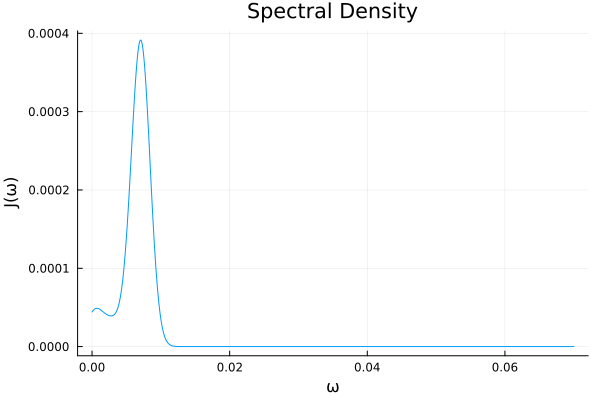

In [54]:
ω = 0:0.0001:0.07
plot(ω, Jw.(ω), xlabel="ω", ylabel="J(ω)", title="Spectral Density", legend=false)

In [82]:
nsteps = 50
ρ0 = Matrix{ComplexF64}(zeros(N, N))
ρ0[1, 1] = 1.0

T = 50.0:50.0:500.0

β = 1 / (T[6] * 3.16683e-6) # T = 300K

1052.5772881188234

Simulation is very sensitive to time-stepping. NaNs get produced if you're not careful

In [83]:
dt = 10/au2fs 

413.4137457575099

In [62]:
d = 0.3

0.3

In [63]:
ωs, cs = discretize(Jw, 100)

([7.259600589e-5, 0.00014519201178, 0.00021778801767000002, 0.00029038402356, 0.00036298002945, 0.00043557603534000004, 0.00050817204123, 0.00058076804712, 0.0006533640530100001, 0.0007259600589  …  0.00660623653599, 0.00667883254188, 0.006751428547770001, 0.00682402455366, 0.00689662055955, 0.006969216565440001, 0.00704181257133, 0.00711440857722, 0.00718700458311, 0.007259600589], [4.568411576327361e-5, 6.51888481319755e-5, 8.04592258579185e-5, 9.351488284617583e-5, 0.0001051152947993999, 0.00011563751540161236, 0.00012529830077687777, 0.00013423482707070172, 0.0001425404703211618, 0.00015028284834202928  …  0.0012488387713103846, 0.0012656843181004863, 0.001280947028922187, 0.0012945536173301, 0.0013064373173929883, 0.0013165383710130223, 0.0013248044751461151, 0.0013311911834765799, 0.0013356622574979453, 0.0013381899624322496])

QCPI doesn't like Gaussian-broadened Spectral Density. Stuck here...

In [64]:
## QCPI Run

#hb = Solvents.HarmonicBath(β, ωp, ωpg0p, [1.0, 2.0, 3.0, 4.0, 5.0].*d, 1000)
hb = Solvents.HarmonicBath(β, ωs, cs, [1.0, 2.0, 3.0, 4.0, 5.0].*d, 1000)
tc, ρc = QCPI.propagate(; Hamiltonian=H0, Jw, solvent=hb, ρ0, classical_dt=dt / 100, dt, ntimes=nsteps, kmax=1, svec=[1.0 2.0 3.0 4.0 5.0].*d, extraargs=QuAPI.QuAPIArgs(), path_integral_routine=QuAPI.propagate)

(0.0:124.02412372725296:16495.20845572464, [1.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.9999067413834979 + 0.0im 0.000575989009081151 - 0.005092585037953681im … 0.0005782319852883533 - 0.0031093496590783466im 0.0 + 0.0im; … ; 0.9778302971759457 - 2.249218187932284e-19im -0.004555590115509604 - 0.0021901167738873216im … -0.0011495761572059072 - 0.0014037752442141746im 0.0 + 0.0im; 0.9776885550071374 - 2.4242039357577947e-19im -0.0014169015834008178 - 0.005890052723724706im … -0.0009465647969236065 - 0.0029057866957057686im 0.0 + 0.0im;;; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.000575989009081151 + 0.005092585037953681im 5.560208263162884e-5 + 0.0im … 1.5620655180612765e-5 + 7.956687961062742e-7im 0.0 + 0.0im; … ; -0.004555590115509608 + 0.002190116773887318im 0.013913492947062255 - 3.625594838903796e-21im … 9.640938206047864e-5 - 4.086727884585998e-5im 0.0 + 0.0im; -0.0014169015834008187 + 0.005890052723724703im 0.013999638908785373 - 3.0607075355829134e-21im … 0.0

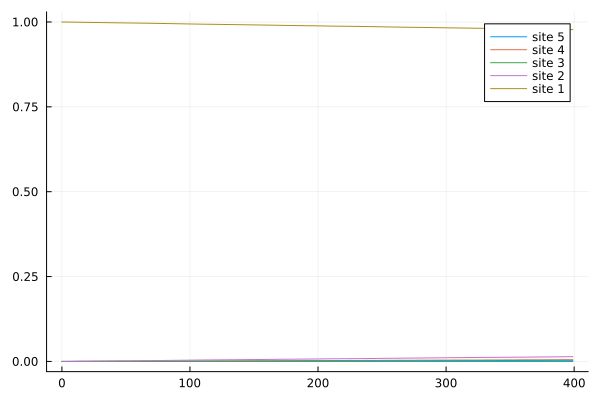

In [65]:
plot(tc.*au2fs, real.(ρc[:, 5, 5]), label="site 5")
plot!(tc.*au2fs, real.(ρc[:, 4, 4]), label="site 4")
plot!(tc.*au2fs, real.(ρc[:, 3, 3]), label="site 3")
plot!(tc.*au2fs, real.(ρc[:, 2, 2]), label="site 2")
plot!(tc.*au2fs, real.(ρc[:, 1, 1]), label="site 1")

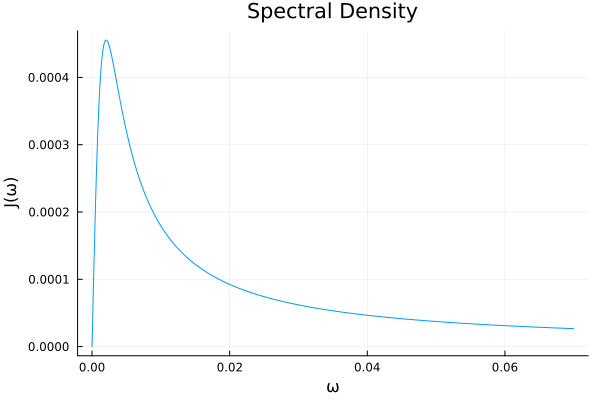

In [79]:
Jw2 = SpectralDensities.DrudeLorentz(λ=100*invcm2au, γ=450*invcm2au, Δs=1.0)
ω = 0:0.0001:0.07
ωs2, cs2 = SpectralDensities.discretize(Jw2, 100)
plot(ω, Jw2.(ω), xlabel="ω", ylabel="J(ω)", title="Spectral Density", legend=false)

QCPI simulation with most similar looking Drude-Lorentz Spectral Density

In [67]:
s1 = Vector{Float64}(zeros(N))
s2 = Matrix{Float64}(zeros(1, N))

for i in 1:N
    s1[i] = i
    s2[i] = i
end

In [68]:
s1

5-element Vector{Float64}:
 1.0
 2.0
 3.0
 4.0
 5.0

In [69]:
s2

1×5 Matrix{Float64}:
 1.0  2.0  3.0  4.0  5.0

In [84]:
hb2 = Solvents.HarmonicBath(β, ωs2, cs2, s1, 1000)
tc2, ρc2 = QCPI.propagate(; Hamiltonian=H0, Jw=Jw2, solvent=hb2, ρ0, classical_dt=dt / 100, dt, ntimes=nsteps, kmax=1, svec=s2, extraargs=QuAPI.QuAPIArgs(), path_integral_routine=QuAPI.propagate)

(0.0:413.4137457575099:20670.687287875495, [1.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.72724497792308 + 0.0im -0.07739060120565477 - 0.32172547090769016im … -0.04946872251580784 + 0.2218662694332513im 0.0 + 0.0im; … ; 0.05337858812105978 + 2.233929889326204e-18im -0.1827823676276354 - 0.008638248130110087im … 0.07313020846675629 + 0.005860371767176328im 0.0 + 0.0im; 0.0676466126523175 + 4.7594797790259053e-20im -0.1782834695035183 + 0.05571070400045442im … 0.07359341269444718 - 0.0019261358498971132im 0.0 + 0.0im;;; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; -0.07739060120565477 + 0.32172547090769016im 0.15213992421582798 + 0.0im … -0.09576946576270239 - 0.04611231329818875im 0.0 + 0.0im; … ; -0.18278236762763544 + 0.008638248130110092im 0.18919051508496149 + 5.9900051963991645e-19im … 0.05978174801263961 - 0.022050406133000203im 0.0 + 0.0im; -0.17828346950351828 - 0.05571070400045441im 0.16441383690109532 + 1.1165738928806629e-18im … 0.05933891321546441 + 0.010150525

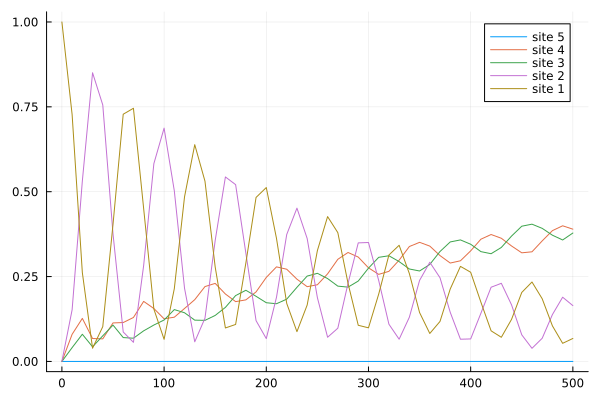

In [85]:
plot(tc2.*au2fs, real.(ρc2[:, 5, 5]), label="site 5")
plot!(tc2.*au2fs, real.(ρc2[:, 4, 4]), label="site 4")
plot!(tc2.*au2fs, real.(ρc2[:, 3, 3]), label="site 3")
plot!(tc2.*au2fs, real.(ρc2[:, 2, 2]), label="site 2")
plot!(tc2.*au2fs, real.(ρc2[:, 1, 1]), label="site 1")

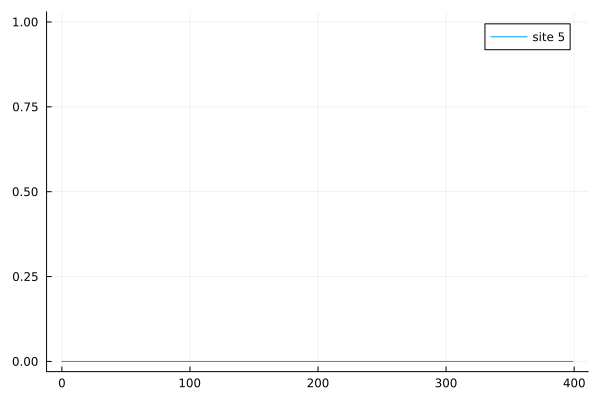

In [73]:
plot(tc2.*au2fs, real.(ρc2[:, 5, 5]), label="site 5")

In [86]:
fbU = Propagators.calculate_bare_propagators(; Hamiltonian=H0, dt=dt, ntimes=nsteps)    
t, ρ = TTM.propagate(; fbU=fbU, Jw=[Jw], β=β, ρ0=ρ0, dt=dt, ntimes=nsteps, rmax=1, extraargs=QuAPI.QuAPIArgs(), path_integral_routine=QuAPI.build_augmented_propagator)

(0.0:413.4137457575099:20670.687287875495, [1.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.7441054374405823 + 0.0im -0.03692039229564373 - 0.34084349353913507im … -0.16598340618916133 + 0.14936754270520072im 0.0 + 0.0im; … ; NaN + NaN*im NaN + NaN*im … NaN + NaN*im NaN + NaN*im; NaN + NaN*im NaN + NaN*im … NaN + NaN*im NaN + NaN*im;;; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; -0.04890285520935405 + 0.33121024599318194im 0.15795799431261665 + 0.0im … -0.06018338309683633 - 0.08344122913751623im 0.0 + 0.0im; … ; NaN + NaN*im NaN + NaN*im … NaN + NaN*im NaN + NaN*im; NaN + NaN*im NaN + NaN*im … NaN + NaN*im NaN + NaN*im;;; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.05368344211854108 + 0.13807894298495255im 0.0632376908705303 - 0.029772135001173386im … -0.03982123058563044 - 0.022061832722262177im 0.0 + 0.0im; … ; NaN + NaN*im NaN + NaN*im … NaN + NaN*im NaN + NaN*im; NaN + NaN*im NaN + NaN*im … NaN + NaN*im NaN + NaN*im;;; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0

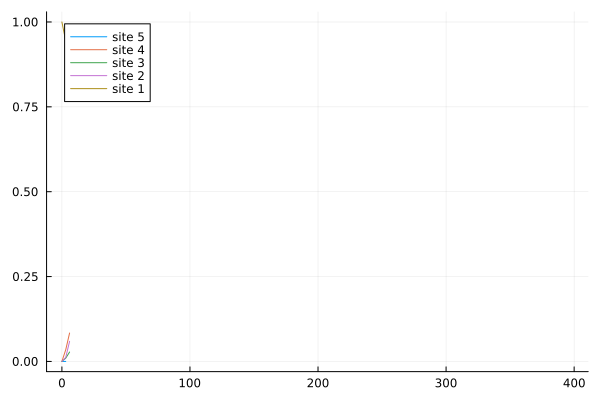

In [75]:
plot(t.*au2fs, real.(ρ[:, 5, 5]), label="site 5")
plot!(t.*au2fs, real.(ρ[:, 4, 4]), label="site 4")
plot!(t.*au2fs, real.(ρ[:, 3, 3]), label="site 3")
plot!(t.*au2fs, real.(ρ[:, 2, 2]), label="site 2")
plot!(t.*au2fs, real.(ρ[:, 1, 1]), label="site 1")

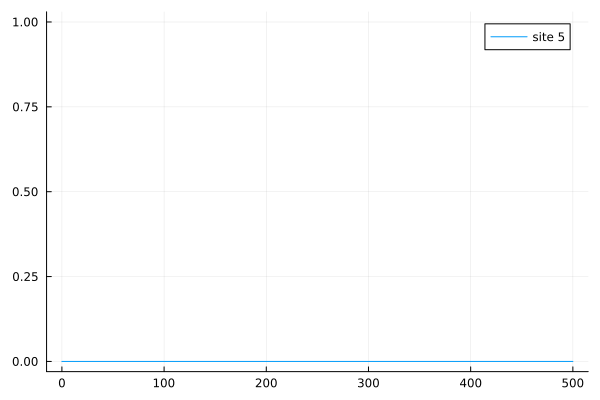

In [25]:
plot(t.*au2fs, real.(ρ[:, 5, 5]), label="site 5")